# **1. Библиотеки**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time
import random

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import cv2
import collections

import torch
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.ticker import MultipleLocator

%matplotlib inline

import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

# **2. Функции**

In [ ]:
def rle_decode_for_plot(mask_rle, shape, color = 1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return 
    color: color for the mask
    Returns numpy array (mask)
    '''
    s = mask_rle.split()
    
    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype = np.float32)
            
    for start, end in zip(starts, ends):
        img[start : end] = color
    
    return img.reshape(shape)


def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [ ]:
def plot_masks(image_id, colors=True):
    labels = df[df["id"] == image_id]["annotation"].tolist()

    if colors:  # (colors=True)
        mask = np.zeros((520, 704, 3))
        for label in labels:
            mask += rle_decode_for_plot(label, shape=(520, 704, 3), color=np.random.rand(3))
    else:
        mask = np.zeros((520, 704, 1))
        for label in labels:
            mask += rle_decode_for_plot(label, shape=(520, 704, 1))
    mask = mask.clip(0, 1)
    
    image = cv2.imread(f"/content/drive/MyDrive/Colab Notebooks/Финальный проект/data/train/{image_id}.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    celltype = df[df.id == image_id].cell_type.unique()[0]

    plt.figure(figsize=(25, 15))
    
    plt.subplot(1, 2, 1)
    plt.title(f'\n Исходное изображение, id: {image_id} \n Тип клетки: {celltype} \n', fontsize=16)
    plt.imshow(image)    
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title(f'\n Маски изображения, id: {image_id} \n Тип клетки: {celltype} \n', fontsize=16)
    plt.imshow(mask)    
    plt.axis("off")

    plt.tight_layout()    
    plt.show()

In [ ]:
def dehance_plot(image_id, colors=True):
    labels = df[df["id"] == image_id]["annotation"].tolist()

    if colors:  # (colors=True)
        mask = np.zeros((520, 704, 3))
        for label in labels:
            mask += rle_decode_for_plot(label, shape=(520, 704, 3), color=np.random.rand(3))
    else:
        mask = np.zeros((520, 704, 1))
        for label in labels:
            mask += rle_decode_for_plot(label, shape=(520, 704, 1))
    mask = mask.clip(0, 1)
    
    celltype = df[df.id == image_id].cell_type.unique()[0]

    plt.figure(figsize=(25, 15))
    
    img = np.array(Image.open(f'/content/drive/MyDrive/Colab Notebooks/Финальный проект/data/train/{image_id}.png'))
    plt.subplot(1, 2, 1)
    plt.title(f'\n Исходное изображение, id: {image_id} \n Тип клетки: {celltype} \n', fontsize=16)
    plt.imshow(np.clip((img - img.mean()), img.min() / img.mean(), img.max() * 0.05), cmap='binary')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(f'\n Исходное изображение, id: {image_id}, совмещенное с ее масками \n Тип клетки: {celltype} \n', fontsize=16)
    plt.imshow(np.clip((img - img.mean()), img.min() / img.mean(), img.max() * 0.05), cmap='binary')
    plt.imshow(mask, alpha=0.25)
    plt.axis("off")

    plt.tight_layout()    
    plt.show()

In [ ]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target
    

def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())
    
    # Аугментация
    if train: 
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))

    return Compose(transforms)

In [ ]:
class CellDataset(Dataset):
    def __init__(self, image_dir, df, transforms=None, resize=False):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df
        
        self.should_resize = resize is not False
        if self.should_resize:
            self.height = int(HEIGHT * resize)
            self.width = int(WIDTH * resize)
        else:
            self.height = HEIGHT
            self.width = WIDTH
        
        self.image_info = collections.defaultdict(dict)
        temp_df = self.df.groupby('id')['annotation'].agg(lambda x: list(x)).reset_index()
        for index, row in temp_df.iterrows():
            self.image_info[index] = {
                    'image_id': row['id'],
                    'image_path': os.path.join(self.image_dir, row['id'] + '.png'),
                    'annotations': row["annotation"]
                    }
    
    def get_box(self, a_mask):
        ''' Get the bounding box of a given mask '''
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]

    def __getitem__(self, idx):
        ''' Get the image and the target'''
        
        img_path = self.image_info[idx]["image_path"]
        img = Image.open(img_path).convert("RGB")
        
        if self.should_resize:
            img = img.resize((self.width, self.height), resample=Image.BILINEAR)

        info = self.image_info[idx]

        n_objects = len(info['annotations'])
        masks = np.zeros((len(info['annotations']), self.height, self.width), dtype=np.uint8)
        boxes = []
        
        for i, annotation in enumerate(info['annotations']):
            a_mask = rle_decode(annotation, (HEIGHT, WIDTH))
            a_mask = Image.fromarray(a_mask)
            
            if self.should_resize:
                a_mask = a_mask.resize((self.width, self.height), resample=Image.BILINEAR)
            
            a_mask = np.array(a_mask) > 0
            masks[i, :, :] = a_mask
            
            boxes.append(self.get_box(a_mask))

        labels = [1 for _ in range(n_objects)]
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        # Таргеты, треубемые моделью Mask R-CNN
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_info)

In [ ]:
def get_model():
    NUM_CLASSES = 3
    
    if NORMALIZE:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, 
                                                                   box_detections_per_img=BOX_DETECTIONS_PER_IMG,
                                                                   image_mean=RESNET_MEAN, 
                                                                   image_std=RESNET_STD)
    else:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                  box_detections_per_img=BOX_DETECTIONS_PER_IMG)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES)
    return model

In [ ]:
def analyze_plot(model, ds_train, sample_index):
    plt.figure(figsize=(25, 15))

    img, targets = ds_train[sample_index]
    plt.subplot(1, 3, 1)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.title("\n Исходное изображение \n")
    plt.axis("off")

    masks = np.zeros((HEIGHT, WIDTH))
    for mask in targets['masks']:
        masks = np.logical_or(masks, mask)
    plt.subplot(1, 3, 2)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.imshow(masks, alpha=0.25, cmap='vlag')
    plt.title("\n Исходное изображение, \n совмещенное с истинными масками \n")
    plt.axis("off")

    model.eval()
    with torch.no_grad():
        preds = model([img.to(DEVICE)])[0]

    plt.subplot(1, 3, 3)
    plt.imshow(img.cpu().numpy().transpose((1,2,0)))
    all_preds_masks = np.zeros((HEIGHT, WIDTH))
    for mask in preds['masks'].cpu().detach().numpy():
        all_preds_masks = np.logical_or(all_preds_masks, mask[0] > MASK_THRESHOLD)
    plt.imshow(all_preds_masks, alpha=0.25, cmap='vlag')
    plt.title("\n Исходное изображение, \n совмещенное с предсказанными масками \n")
    plt.axis("off")


    plt.tight_layout()    
    plt.show()

In [ ]:
class CellTestDataset(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.image_ids = [f[:-4]for f in os.listdir(self.image_dir)]
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.png')
        image = Image.open(image_path).convert("RGB")

        if self.transforms is not None:
            image, _ = self.transforms(image=image, target=None)
        return {'image': image, 'image_id': image_id}

    def __len__(self):
        return len(self.image_ids)

In [ ]:
def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

In [ ]:
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

In [ ]:
def dehance_image(image_id):
    img = np.array(Image.open(f'/content/drive/MyDrive/Colab Notebooks/Финальный проект/data/train/{image_id}.png'))
    d_img = cv2.bitwise_not(np.clip((img - img.mean()), 0, 255).astype(np.uint8))
    d_img = np.where(d_img < 253, 0, d_img)
    return d_img

# **3. Загрузка данных**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Финальный проект/data/train.csv')

Размер датасета:

# **4. Анализ данных**

Размер датасета:

In [ ]:
df.shape

(73585, 9)

Сэмпл датасета:

In [ ]:
df.head(5)

id  ... elapsed_timedelta
0  0030fd0e6378  ...   0 days 11:30:00
1  0030fd0e6378  ...   0 days 11:30:00
2  0030fd0e6378  ...   0 days 11:30:00
3  0030fd0e6378  ...   0 days 11:30:00
4  0030fd0e6378  ...   0 days 11:30:00

[5 rows x 9 columns]

В датасете 606 уникальных изображений:

In [ ]:
df.id.nunique()

606

На которых в целом размечено 73470 объектов (клеток трех типов):

In [ ]:
df.annotation.nunique()

73470

Все изображения имеют один размер 704х520 пикселей:

In [ ]:
df.width.unique()[0], df.height.unique()[0]

(704, 520)

Рассмотрим распределение клеток по типам:

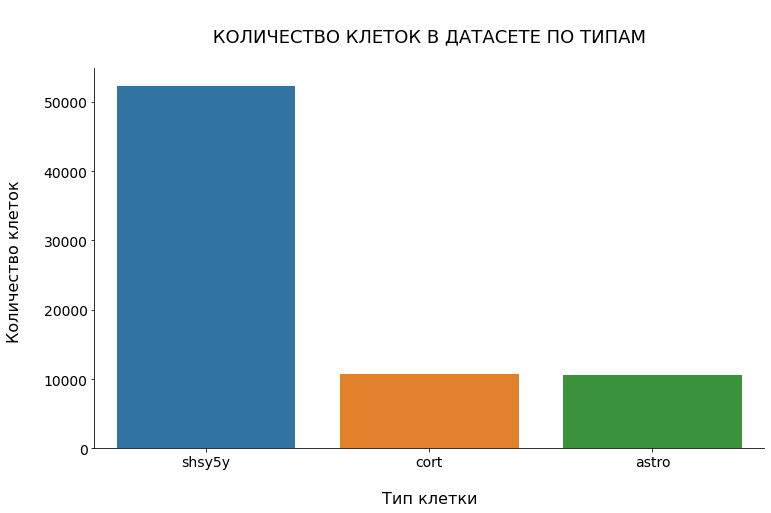

In [ ]:
plt.figure(figsize=(12, 7))
plt.title('\n КОЛИЧЕСТВО КЛЕТОК В ДАТАСЕТЕ ПО ТИПАМ \n', fontsize=18)
sns.barplot(x=df.cell_type.value_counts().index, y=df.cell_type.value_counts().values)
plt.xlabel('\nТип клетки', fontsize = 16)
plt.ylabel('Количество клеток \n', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
sns.despine()

Видно, что в датасете 3 вида клеток: shsy5y, cort, astro. И клеток типа shsy5y в пять раз больше клеток остальных типов.

Угулубимся в предметную область:

- cort - кортекс, клетки коры головного мозга, разделяются на два основных отдела: шестислойный изокортекс (некортекс) и не-изокортекс.


- astro - тип нейроглиальной клетки звёздчатой формы с многочисленными отростками. Астроциты делятся на фиброзные (волокнистые) и плазматические.


- shsy5y - клеточная линия, используемая в научных исследованиях. Исходная клеточная линия, называемая SK-N-SH, из которой она была субклонирована, была выделена из биопсии костного мозга, взятой у четырехлетней женщины с нейробластомой. Клетки SH-SY5Y часто используются в качестве моделей функции и дифференцировки нейронов in vitro. Они являются адренергическими по фенотипу, но также экспрессируют дофаминергические маркеры, использовались для изучения болезни Паркинсона, нейрогенеза и других характеристик клеток головного мозга.

Без лишних объяснений становится понятно, почему датасет несбалансирован в сторону данных клеток.

Судя по медицинским статьям, изучение форм клеток идет до сих пор.
Датасет умалчивает о подтипах представленных клеток, на основе чего можно сделать вывод, что даже успешная модель в данной задаче не может претендовать на исчерпывающее решение проблемы сегментации нервных клеток.


Рассмотрим изображения и отобразим на них размеченные маски:

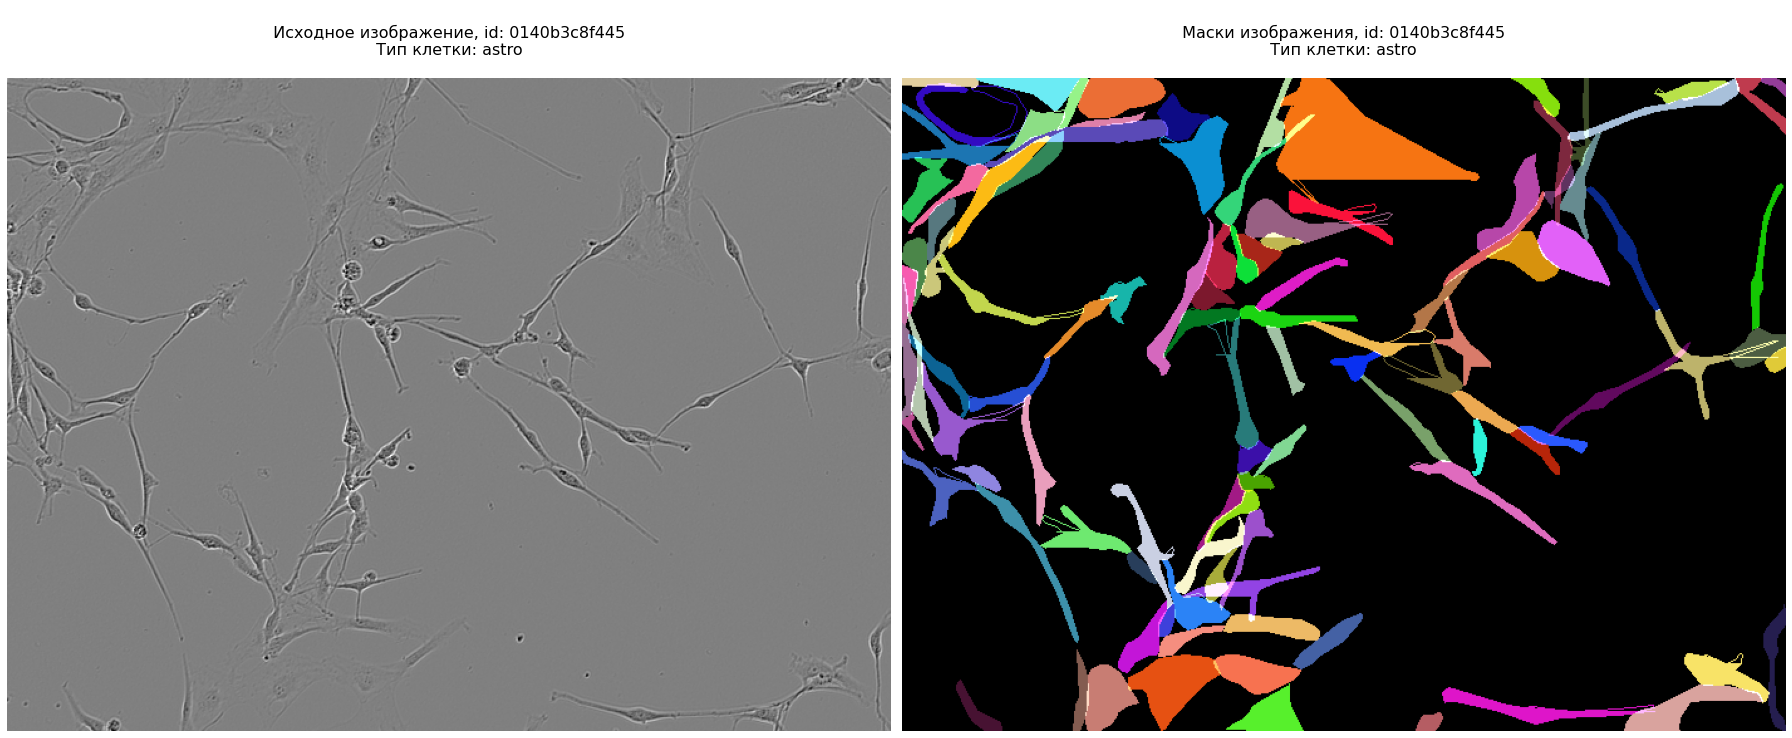

In [ ]:
plot_masks('0140b3c8f445')

Видим, что изображения фазово-контрастной микроскопии в оттенках серого, низкоконтрастные, яркости которых сосредоточены относительно среднего значения 128 единиц.

Справа на изображении представлены только маски размеченных клеток.

Попробуем повысить читаемость исходных изображений с помощью способа, известного всем фотолюбителям, а именно сместим все значения яркостей изображения к середине (центрируем) и повысим контрастность, установив свои значения точки белого и точки черного.

# **5. Повышение информативности**

In [ ]:
dehance_plot('0140b3c8f445')

Изображение стало гораздо информативнее, четко видны границы клеток, фон не мешает восприятию. Однако некоторые структуры просматриваются хуже остальных, данный факт связан с тем, что изображение - снимок пространственных структур, одни лежат ближе к регистратору, другие дальше. К тому же разные структуры обладают различными оптическими плотностями.


Также можем наблюдать, что некоторые клетки размечены четко по контуру, а некоторые приблизительно, например, структура в зеленом треугольнике сверху посередине - видно, что структура не замыкается, как указывает на то маска. Это одна возможных проблем при сегментации клеток и обучении модели.

Выберем случайные изображения из всего датасета и посмотрим как работатем наш собственный алгоритм повышения информативности:

In [ ]:
images = df.id.unique().tolist()
images_to_plot = np.random.choice(images, 16)
for i in range(8):
    image = images_to_plot[i]
    dehance_plot(image)
plt.tight_layout()
plt.show()

In [ ]:
# images = df.id.unique().tolist()
# for _ in images:
#     cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/Финальный проект/data/dehanced_images/' + str(_) + '.png', dehance_image(_))

# **6. Модель**

In [ ]:
TRAIN_CSV = "/content/drive/MyDrive/Colab Notebooks/Финальный проект/data/train.csv"
TRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/Финальный проект/data/dehanced_images"
# TRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/Финальный проект/data/train"
TEST_PATH = "/content/drive/MyDrive/Colab Notebooks/Финальный проект/data/test"

WIDTH = 704
HEIGHT = 520

TEST = False

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

BATCH_SIZE = 2

MOMENTUM = 0.9
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005

MASK_THRESHOLD = 0.5

NORMALIZE = False 

USE_SCHEDULER = False

NUM_EPOCHS = 12

BOX_DETECTIONS_PER_IMG = df.groupby(by='id').agg(lambda k: len(k)).annotation.max()

MIN_SCORE = 0.59

In [ ]:
model = get_model()
model.to(DEVICE)

for param in model.parameters():
    param.requires_grad = True
    
model.train()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
df_images = df.groupby(["id", "cell_type"]).agg({'annotation': 'count'}).sort_values("annotation", ascending=False).reset_index()
df_images_train, df_images_val = train_test_split(df_images, stratify=df_images['cell_type'], test_size=0.09)
df_train = df[df['id'].isin(df_images_train['id'])]
df_val = df[df['id'].isin(df_images_val['id'])]
print(f"Images in train set:           {len(df_images_train)}")
print(f"Annotations in train set:      {len(df_train)}")
print(f"Images in validation set:      {len(df_images_val)}")
print(f"Annotations in validation set: {len(df_val)}")

Images in train set:           551
Annotations in train set:      66452
Images in validation set:      55
Annotations in validation set: 7133


In [ ]:
ds_train = CellDataset(TRAIN_PATH, df, resize=False, transforms=get_transform(train=True))
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
ds_val = CellDataset(TRAIN_PATH, df_val, resize=False, transforms=get_transform(train=True))
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

n_batches, n_batches_val = len(dl_train), len(dl_val)

losses = []
validation_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch {epoch} / {NUM_EPOCHS}")
    
    time_start = time.time()
    loss_accum = 0.0
    # loss_mask_accum = 0.0
    
    for batch_idx, (images, targets) in enumerate(dl_train, 1):
    
        # Predict
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Logging
        # loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        # loss_mask_accum += loss_mask
        
        if batch_idx % 50 == 0:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}")
    
    if USE_SCHEDULER:
        lr_scheduler.step()
    
    # Train losses
    train_loss = loss_accum / n_batches

    losses.append(train_loss)
    
    # Validation 
    val_loss_accum = 0
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dl_val, 1):
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            
            val_loss_dict = model(images, targets)
            val_batch_loss = sum(loss for loss in val_loss_dict.values())
            val_loss_accum += val_batch_loss.item()
    
    # Validation losses
    val_loss = val_loss_accum / n_batches_val

    elapsed = time.time() - time_start
    
    validation_losses.append(val_loss)
    
    torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
    prefix = f"[Epoch {epoch:2d} / {NUM_EPOCHS:2d}]"
    print(f"{prefix} Train loss: {train_loss:7.3f}. Val loss: {val_loss:7.3f} [{elapsed:.0f} secs]")

Epoch 1 / 12
    [Batch  50 / 303] Batch train loss:   2.014
    [Batch 100 / 303] Batch train loss:   2.113
    [Batch 150 / 303] Batch train loss:   1.799
    [Batch 200 / 303] Batch train loss:   1.830
    [Batch 250 / 303] Batch train loss:   1.403
    [Batch 300 / 303] Batch train loss:   2.141
[Epoch  1 / 12] Train loss:   1.760. Val loss:   1.644 [171 secs]
[Epoch  1 / 12]
Epoch 2 / 12
    [Batch  50 / 303] Batch train loss:   1.346
    [Batch 100 / 303] Batch train loss:   1.432
    [Batch 150 / 303] Batch train loss:   1.661
    [Batch 200 / 303] Batch train loss:   1.341
    [Batch 250 / 303] Batch train loss:   1.745
    [Batch 300 / 303] Batch train loss:   1.681
[Epoch  2 / 12] Train loss:   1.581. Val loss:   1.557 [172 secs]
[Epoch  2 / 12]
Epoch 3 / 12
    [Batch  50 / 303] Batch train loss:   1.618
    [Batch 100 / 303] Batch train loss:   1.338
    [Batch 150 / 303] Batch train loss:   1.598
    [Batch 200 / 303] Batch train loss:   1.554
    [Batch 250 / 303] Batch t

In [ ]:
all_losses = pd.DataFrame(data=losses, index=np.arange(1,13), columns=['train'])
all_losses['validation'] = validation_losses

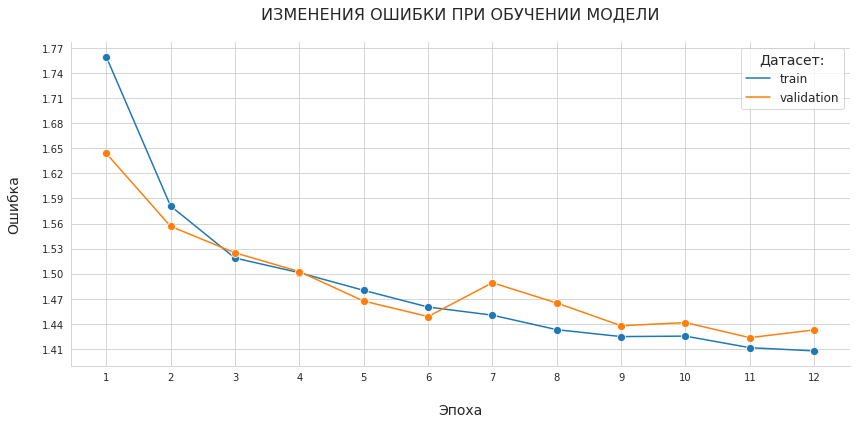

In [ ]:
sns.set_style(style='whitegrid')
sns.set_context(rc = {'lines.linewidth': 1.5, 'lines.markersize': 8})

plt.figure(figsize=(12, 6))

lnplt = sns.lineplot(
    data=all_losses,
    marker='o', dashes=False)

lnplt.set_title(str.upper('изменения ошибки при обучении модели\n'), fontsize=16)
lnplt.legend(title_fontsize=14, fontsize=12, title='Датасет:')
lnplt.set_ylabel("Ошибка\n", fontsize=14)
lnplt.set_xlabel("\nЭпоха", fontsize=14)
lnplt.xaxis.set_major_locator(MultipleLocator(1))
lnplt.yaxis.set_major_locator(MultipleLocator(0.03))

sns.despine()
plt.tight_layout()
plt.show()

# **7. Проверка предсказаний**

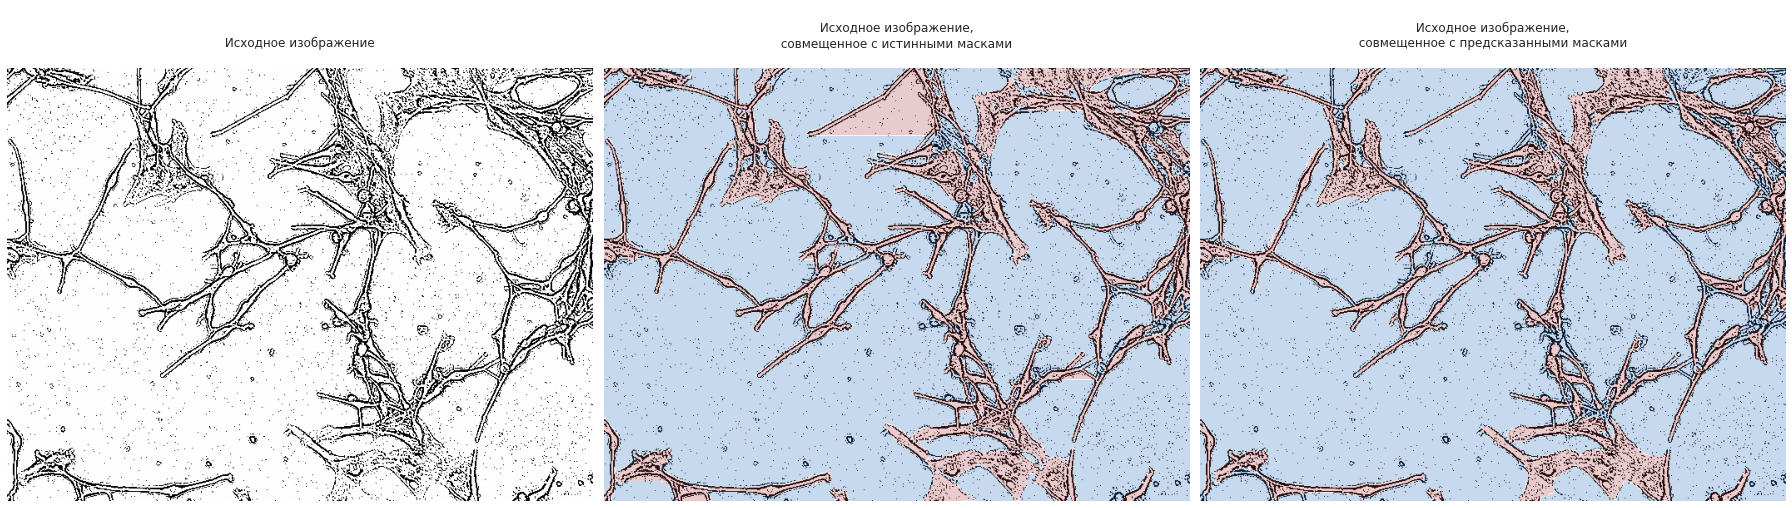

In [ ]:
analyze_plot(model, ds_train, 1)

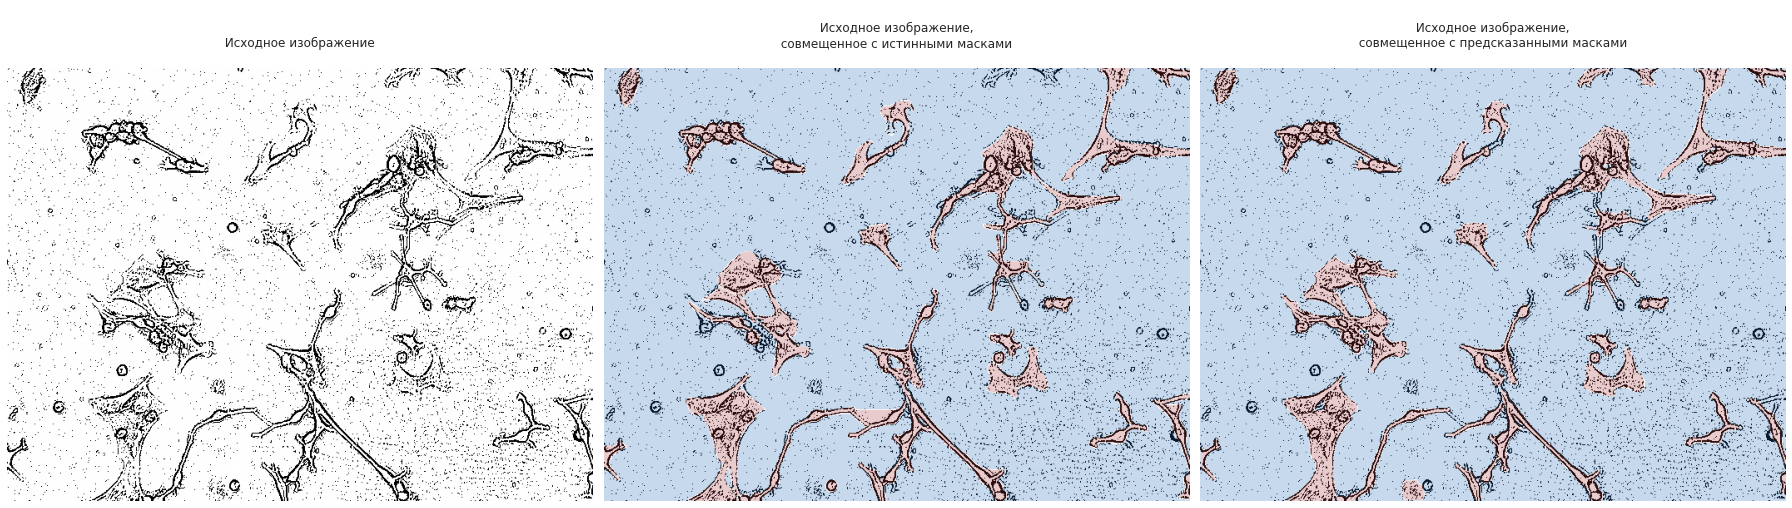

In [ ]:
analyze_plot(model, ds_train, 220)

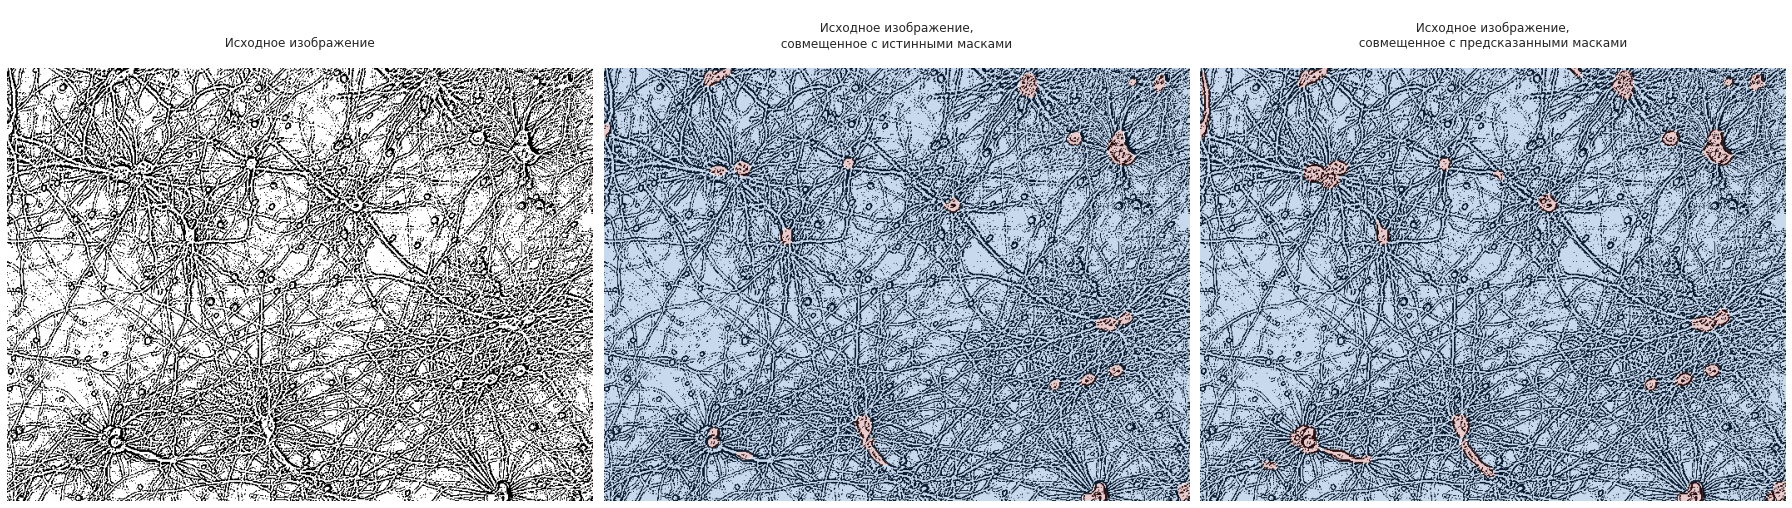

In [ ]:
analyze_plot(model, ds_train, 5)